# Task 3 - Optimizers
This Source Code was prepared by instructor Stefan Grivalsky.


**Requirements:**
 - numpy (https://numpy.org/)
 - sklearn (https://scikit-learn.org/stable/)
 - matplotlib (https://matplotlib.org/)
 

In this task, we prepared for you a mini-deep learning framework inspired by [PyTorch](https://pytorch.org/).
It has same functions as your previous tasks, with some differences in implementation. Let's dive into it.

In [1]:
# Import
import numpy as np
from fn import gradient_check_n, softmax, identity
from collections import OrderedDict

from dataset import dataset_Circles
from sklearn import datasets
from matplotlib import pyplot as plt

## Tensor

Tensor is an upgraded version of numpy types. Tensor can encapsulate any numpy scalars and arrays. It has one required argument in inicialization - **data** (np.ndarray or np.generic). Second argument **requires_grad** is optional and it is used in optimalization.

In backpropagation process, gradients are stored in attribute **grad**. The attribute **state** is used in optimizers, where you can store, for example, exponentially weighted averages. Tensor has also implemented some of basic operation such as +, -, /, \*, @ and \*\*, what allows us to use classic operators (Tensor*Tensor).

In [2]:
#------------------------------------------------------------------------------
#   Tensor class
#------------------------------------------------------------------------------
class Tensor:
    def __init__(self, data: np.ndarray, requires_grad=False):
        if not isinstance(data, (np.ndarray, np.generic)):
            raise AttributeError("data must be np.ndarray")
        self.data = data
        self.shape = self.data.shape
        self.requires_grad = requires_grad
        self.grad = None
        self.state = {}

    def transpose(self):
        return Tensor(np.transpose(self.data))

    def __getitem__(self, *args):
        return self.data[args]

    def __str__(self):
        return str(self.data)

    def __matmul__(self, other):
        return Tensor(data=np.matmul(self.data, other.data))

    def __mul__(self, other):
        return Tensor(data=self.data * other.data)

    def __add__(self, other):
        return Tensor(data=(self.data + other.data))

    def __pow__(self, power, modulo=None):
        return Tensor(data=self.data ** power)

    def __sub__(self, other):
        return Tensor(data=(self.data - other.data))

    def __truediv__(self, other):
        return Tensor(data=(self.data / other.data))
    

## Module

All deep learning frameworks have usually one elementary building block. In our project, we follow the structure Pytorch, so the elementary building block is called **Module**. It has many great features, so you should definitely look deeper into the source code to understand it.

In [3]:
#------------------------------------------------------------------------------
#   Module class
#------------------------------------------------------------------------------
class Module:
    def __init__(self):
        self._modules = OrderedDict()
        self._parameters = OrderedDict()

    def add_module(self, name, module):
        if hasattr(self, name) and name not in self._modules:
            raise KeyError("attribute '{}' already exists".format(name))
        elif '.' in name:
            raise KeyError("module name can't contain \".\"")
        elif name == '':
            raise KeyError("module name can't be empty string \"\"")
        self._modules[name] = module

    def register_parameter(self, name, param):
        if '.' in name:
            raise KeyError("parameter name can't contain \".\"")
        elif name == '':
            raise KeyError("parameter name can't be empty string \"\"")
        elif hasattr(self, name) and name not in self._parameters:
            raise KeyError("attribute '{}' already exists".format(name))
        else:
            self._parameters[name] = param

    def parameters(self, recurse=True):
        for name, param in self._parameters.items():
            if param.requires_grad:
                yield name, param
        if recurse:
            for name, module in self._modules.items():
                for name, param in module.parameters(recurse):
                    if param.requires_grad:
                        yield name, param

    def __dir__(self):
        module_attrs = dir(self.__class__)
        attrs = list(self.__dict__.keys())
        modules = list(self._modules.keys())
        parameters = list(self._parameters.keys())
        keys = module_attrs + attrs + modules + parameters

        # Eliminate attrs that are not legal Python variable names
        keys = [key for key in keys if not key[0].isdigit()]

        return sorted(keys)

    def __getattr__(self, name: str):
        if '_modules' in self.__dict__:
            modules = self.__dict__['_modules']
            if name in modules:
                return modules[name]
        if '_parameters' in self.__dict__:
            parameters = self.__dict__['_parameters']
            if name in parameters:
                return parameters[name]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, name))

    def __setattr__(self, name, value):
        if isinstance(value, Module):
            self._modules[name] = value
        elif isinstance(value, Tensor):
            self.register_parameter(name, value)
        else:
            object.__setattr__(self, name, value)

    def backward(self, *args, **kwargs) -> np.ndarray:
        pass

    def forward(self, *args, **kwargs) -> Tensor:
        pass

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def __iter__(self):
        return iter(self._modules.values())

    def __reversed__(self):
        return iter(reversed(self._modules.values()))
    

## Linear Layer

In your previous tasks, you defined your own Linear class with forward and backward. In this little framework, the activation function and linear unit are separated. This separation is beneficial for backward propagation and for Optimization. (If you want to know why, take a look on implementation of forward and backward propagation in class Model.)

In [4]:
#------------------------------------------------------------------------------
#   Linear class
#------------------------------------------------------------------------------
class Linear(Module):
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.W = Tensor(np.random.randn(out_features, in_features), requires_grad=True)
        self.b = Tensor(np.zeros((out_features, 1)), requires_grad=True)
        self.train = True

    def forward(self, input: Tensor) -> Tensor:
        if self.train:
            self.fw_inputs = input.data
        net = self.W @ input + self.b
        if self.train:
            self.net = net.data
        return net

    def backward(self, dNet) -> np.ndarray:
        batch_size = self.fw_inputs.shape[1]
        self.W.grad = 1. / batch_size * np.dot(dNet, self.fw_inputs.T)
        self.b.grad = 1. / batch_size * np.sum(dNet, axis=1, keepdims=True)
        return np.dot(self.W.transpose().data, dNet)
    

## Activations

As we mentioned in previous cell, in this framework, we separate linear unit and activation. There are implementations of Sigmoid and ReLU activation functions with forward and backward pass.

In [5]:
#------------------------------------------------------------------------------
#   SigmoidActivationFunction class
#------------------------------------------------------------------------------
class Sigmoid(Module):
    def __init__(self):
        super(Sigmoid, self).__init__()

    def forward(self, input: Tensor) -> Tensor:
        self.fw_inputs = input
        return Tensor(1.0 / (1.0 + np.exp(-input.data)))

    def backward(self, dNet) -> np.ndarray:
        net = self(self.fw_inputs).data
        return np.multiply(dNet, np.multiply(net, 1 - net))

#------------------------------------------------------------------------------
#   RELUActivationFunction class
#------------------------------------------------------------------------------
class ReLU(Module):
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, input: Tensor) -> Tensor:
        self.fw_inputs = input
        return Tensor(np.maximum(input.data, 0))

    def backward(self, dNet) -> np.ndarray:
        return np.multiply(dNet, np.int64(self.fw_inputs.data > 0))
    

## Loss Functions

As in standard deep learning frameworks, calling Loss function can return either **cost** or  **loss** based on parameter **reduce**.

In [6]:
#------------------------------------------------------------------------------
#   MeanSquareErrorLossFunction class
#------------------------------------------------------------------------------
class MSELoss(Module):
    def __init__(self, reduce="mean"):
        super(MSELoss, self).__init__()
        if reduce == "mean":
            self.reduce_fn = np.mean
        elif reduce == "sum":
            self.reduce_fn = np.sum
        elif reduce is None:
            self.reduce_fn = identity
        else:
            raise AttributeError

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        return Tensor(self.reduce_fn(np.mean(np.power(target.data - input.data, 2), axis=0, keepdims=True)))

    def backward(self, input: Tensor, target: Tensor) -> np.ndarray:
        return np.mean(-2 * (target.data - input.data), axis=0, keepdims=True)


#------------------------------------------------------------------------------
#   BinaryCrossEntropyLossFunction class
#------------------------------------------------------------------------------
class BCELoss(Module):
    def __init__(self, reduce="mean"):
        super(BCELoss, self).__init__()
        if reduce == "mean":
            self.reduce_fn = np.mean
        elif reduce == "sum":
            self.reduce_fn = np.sum
        elif reduce is None:
            self.reduce_fn = identity
        else:
            raise AttributeError

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        return Tensor(self.reduce_fn(
            -(target.data * np.log(input.data) + np.multiply((1 - target.data), np.log(1 - input.data)))))

    def backward(self, input: Tensor, target: Tensor) -> np.ndarray:
        return np.divide(-target.data, input.data) + np.divide(1 - target.data, 1 - input.data)


#------------------------------------------------------------------------------
#   CrossEntropyLossFunctionWithSoftmax class
#------------------------------------------------------------------------------
class CrossEntropyLossWithSoftmax(Module):
    def __init__(self, reduce="mean"):
        super(CrossEntropyLossWithSoftmax, self).__init__()
        if reduce == "mean":
            self.reduce_fn = np.mean
        elif reduce == "sum":
            self.reduce_fn = np.sum
        elif reduce is None:
            self.reduce_fn = identity
        else:
            raise AttributeError

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        p = np.log(softmax(input.data))
        return Tensor(-self.reduce_fn(np.sum(target.data * p, axis=0, keepdims=True)))

    def backward(self, input: Tensor, target: Tensor) -> np.ndarray:
        p = softmax(input.data)
        return (p - target.data)

## Optimizers

Each optimizer has as first required parameter **parameters_gen**. It is function for accessing all trainable parameters of Model. Other optimizer attributes are based on the optimizer definition.

**Your task is to implement:**
 - SGD with momentum
 - RMSProp: http://www.cs.toronto.edu/~hinton/coursera/lecture6/lec6.pdf
 - Adam: https://arxiv.org/pdf/1412.6980.pdf 



In [7]:
#------------------------------------------------------------------------------
#   AbstractOptimizer class
#------------------------------------------------------------------------------
class Optimizer:
    def __init__(self):
        pass

    def step(self):
        raise NotImplemented

#------------------------------------------------------------------------------
#   StochasticGradientDescentOptimizer class
#------------------------------------------------------------------------------
class SGD(Optimizer):
    def __init__(self, parameters_gen, lr):
        super(SGD, self).__init__()
        self.parameters_gen = parameters_gen
        self.lr = lr

    def step(self):
        for name, parameter in self.parameters_gen():
            parameter.data -= self.lr * parameter.grad


#------------------------------------------------------------------------------
#   SGDMomentumOptimizer class
#------------------------------------------------------------------------------            
class SGDMomentum(Optimizer):
    def __init__(self, parameters_gen, lr, beta):
        super(SGDMomentum, self).__init__()
        self.parameters_gen = parameters_gen
        self.lr = lr
        self.beta = beta
        
    def step(self):
        for name, parameter in self.parameters_gen():
            if "momentum" in parameter.state:
                # VdW := (1-beta)dW + beta VdW
                # Vdb := (1-beta)db + beta Vdb
                parameter.state["momentum"] = (1 - self.beta) * parameter.grad + self.beta * parameter.state["momentum"]
            else:
                parameter.state["momentum"] = (1 - self.beta) * parameter.grad
            
            parameter.data -= self.lr * parameter.state["momentum"]
    
#------------------------------------------------------------------------------
#   RMSpropOptimizer class
#------------------------------------------------------------------------------
class RMSprop(Optimizer):
    def __init__(self, parameters_gen, lr, beta, epsilon=1e-8):
        super(RMSprop, self).__init__()
        self.parameters_gen = parameters_gen
        self.lr = lr
        self.beta = beta
        self.epsilon = epsilon

    def step(self):
        for name, parameter in self.parameters_gen():
            if "square_avg" in parameter.state:
                parameter.state["square_avg"] = (1 - self.beta) * np.square(parameter.grad) + self.beta * parameter.state["square_avg"]
            else:
                parameter.state["square_avg"] = (1 - self.beta) * np.square(parameter.grad)
           
            # W := W - lr * (dW / sqrt(SdW))
            # b := b - lr * (db / sqrt(Sdb))
            parameter.data -= self.lr * np.divide(parameter.grad, np.sqrt(parameter.state["square_avg"] + self.epsilon))
    


#------------------------------------------------------------------------------
#   AdamOptimizer class
#------------------------------------------------------------------------------
class Adam(Optimizer):
    def __init__(self, parameters_gen, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super(Adam, self).__init__()
        self.parameters_gen = parameters_gen
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
    def step(self):
        t = 0
        for name, parameter in self.parameters_gen():
            t += 1
            
            if "exp_avg" in parameter.state and "exp_avg_sq" in parameter.state:
                parameter.state["exp_avg"] = (1 - self.beta1) * parameter.grad + self.beta1 * parameter.state["exp_avg"]
                parameter.state["exp_avg_sq"] =  (1 - self.beta2)* np.square(parameter.grad) + self.beta2 * parameter.state["exp_avg_sq"]
            else:
                parameter.state["exp_avg"] = (1 - self.beta1) * parameter.grad
                parameter.state["exp_avg_sq"] = (1 - self.beta2) * np.square(parameter.grad)


            exp_avg_corrected = np.divide(
                parameter.state["exp_avg"], 
                (1 - np.power(self.beta1, t)) + self.epsilon
            )
                
            exp_avg_sq_corrected = np.divide(
                parameter.state["exp_avg_sq"], 
                (1 - np.power(self.beta2, t)) + self.epsilon
            )
                
            parameter.data -= self.lr * np.divide(
                exp_avg_corrected, 
                np.sqrt(exp_avg_sq_corrected) + self.epsilon
            )


## Model class

Implementation of the **Model** class. In the constructor you can define layers and activations for the model. Pay attention to the order of definition of the layers. The implementation of forward and backward pass is sensitive to the order. Each attribute of type **Module** saves the value to the private atribute **Module._modules**. Type of **Module._modules** is OrderedDict which is sensitive to the order. This OrderedDict is used in forward and backward propagation.

You can also define your own forward and backward pass, but use **gradient_check_n** to check your implementation.

Another way of network definition is to keep **\__init__** empty and add modules after construction of the class:

```
net = Module()
net.add_module("input", Linear(2, 125))
net.add_module("input_a", ReLU())
net.add_module("output", Linear(125, 1))
net.add_module("output_a", Sigmoid())

```


In [8]:
#------------------------------------------------------------------------------
#   Model class
#------------------------------------------------------------------------------
class Model(Module):
    def __init__(self):
        super(Model, self).__init__()
        self.input = Linear(2, 13)
        self.input_a = ReLU()
        self.hidden_1 = Linear(13, 56)
        self.hidden_1_a = ReLU()
        self.hidden_2 = Linear(56, 36)
        self.hidden_2_a = ReLU()
        self.output = Linear(36, 1)
        self.output_a = Sigmoid()

    def forward(self, input):
        for module in self:
            input = module(input)
        return input

    def backward(self, dA: np.ndarray):
        for module in reversed(self):
            dA = module.backward(dA)

# Train Model with Optimizer

In [9]:
# Get and prepare dataset
inputs, targets = dataset_Circles(batch_size=256, radius=0.7, noise=0.0)

# dataset_Circles return X and Y as numpy arrays. To train our model on the dataset, we have to transform the data to Tensor object.
inputs, targets = Tensor(inputs), Tensor(targets)

# Define your model, criterion(loss and cost function) and optimizer
net = Model()

criterion = MSELoss()

# Change the optimizer
# optimizer = SGD(net.parameters, lr=0.01)
# optimizer = SGDMomentum(net.parameters, lr=0.01, beta=0.9)
optimizer = RMSprop(net.parameters, lr=0.005, beta=0.9)
# optimizer = Adam(net.parameters, lr=0.005, beta1=0.9, beta2=0.9)

# Train cycle
num_epochs = 100
losses = []
for i in range(num_epochs):
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    losses.append(loss.data)
    dLoss = criterion.backward(outputs, targets)
    net.backward(dLoss)
    optimizer.step()

print("Train accuracy:", np.mean(np.float32(targets.data == np.array(outputs.data > 0.5, dtype=np.int8))))

Train accuracy: 0.98046875


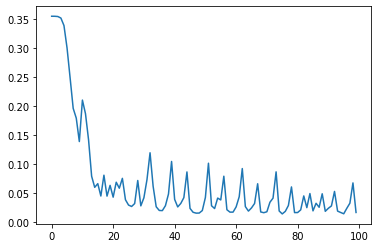

In [10]:
#Visualize your optimization
plt.plot(losses)
plt.show()

# Compare Optimizers

Define each run for comparison with different optimizers. We need to use **np.random.seed()** to have same values for initialization of weights and biases.

In [11]:
optimizer_trains = {}

# SGD training
np.random.seed(10)
net = Model()
optimizer = SGD(net.parameters, lr=0.01)
optimizer_trains["SGD"] = {
    "net": net,
    "optimizer": optimizer,
    "losses": None
}

# SGDMomentum training
np.random.seed(10)
net = Model()
optimizer = SGDMomentum(net.parameters, lr=0.01, beta=0.9)
optimizer_trains["SGDMomentum"] = {
    "net": net,
    "optimizer": optimizer,
    "losses": None
}

# RMSprop training
np.random.seed(10)
net = Model()
optimizer = RMSprop(net.parameters, lr=0.005, beta=0.9)
optimizer_trains["RMSprop"] = {
    "net": net,
    "optimizer": optimizer,
    "losses": None
}

# Adam training
np.random.seed(10)
net = Model()
optimizer = Adam(net.parameters, lr=0.005, beta1=0.9, beta2=0.9)
optimizer_trains["Adam"] = {
    "net": net,
    "optimizer": optimizer,
    "losses": None
}

In [12]:
# Get and prepare dataset
inputs, targets = dataset_Circles(batch_size=256, radius=0.7, noise=0.0)
inputs, targets = Tensor(inputs), Tensor(targets)

# Criterion
criterion = MSELoss(reduce="mean")

num_epochs = 200
for key, values in optimizer_trains.items():
    net = values["net"]
    optimizer = values["optimizer"]
    losses = []
    for i in range(num_epochs):
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.data)
        dLoss = criterion.backward(outputs, targets)
        net.backward(dLoss)
        optimizer.step()
    optimizer_trains[key]["losses"] = losses
    print(key, "train:", np.mean(np.float32(targets.data == np.array(outputs.data > 0.5, dtype=np.int8))))

SGD train: 0.5625
SGDMomentum train: 0.6015625
RMSprop train: 0.98046875
Adam train: 1.0


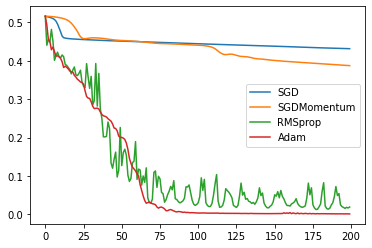

In [13]:
for serie in optimizer_trains.values():
    plt.plot(range(num_epochs), serie["losses"])

    
plt.legend(optimizer_trains.keys())
plt.show()

## OPTIONAL: Train your network on Iris dataset and compare Optimizers

Iris - https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [14]:
# Get Iris dataset
dataset = datasets.load_iris()
train_inputs, train_targets = dataset.data.T, dataset.target

# Normalize Iris inputs -> train_inputs: Tensor
# >>>> start_solution
train_inputs = None
# <<<< end_solution

# Transform Iris targets to one-hot-encoding -> train_targets: Tensor, train_targets_1h: Tensor
one_hot = np.eye(3)
# >>>> start_solution
train_targets = None
train_targets_1h = None
# <<<< end_solution

In [15]:
#------------------------------------------------------------------------------
#   Model class
#------------------------------------------------------------------------------
class IrisModel(Module):
    def __init__(self):
        super(IrisModel, self).__init__()
        # >>>> start_solution
        # <<<< end_solution

    def forward(self, input):
        for module in self:
            input = module(input)
        return input

    def backward(self, dA: np.ndarray):
        for module in reversed(self):
            dA = module.backward(dA)


In [16]:
optimizer_trains = {}

# SGD training
np.random.seed(10)
net = IrisModel()
optimizer = SGD(net.parameters, lr=0.01)
optimizer_trains["SGD"] = {
    "net": net,
    "optimizer": optimizer,
    "losses": None
}

# SGDMomentum training
np.random.seed(10)
net = IrisModel()
# >>>> start_solution
optimizer = None
# <<<< end_solution
optimizer_trains["SGDMomentum"] = {
    "net": net,
    "optimizer": optimizer,
    "losses": None
}

# RMSprop training
np.random.seed(10)
net = IrisModel()
# >>>> start_solution
optimizer = None
# <<<< end_solution
optimizer_trains["RMSprop"] = {
    "net": net,
    "optimizer": optimizer,
    "losses": None
}

# Adam training
np.random.seed(10)
net = IrisModel()
# >>>> start_solution
optimizer = None
# <<<< end_solution
optimizer_trains["Adam"] = {
    "net": net,
    "optimizer": optimizer,
    "losses": None
}

In [17]:
# Criterion
criterion = CrossEntropyLossWithSoftmax(reduce="mean")

num_epochs = 100
for key, values in optimizer_trains.items():
    net = values["net"]
    optimizer = values["optimizer"]
    losses = []
    for i in range(num_epochs):
        outputs = net(train_inputs)
        loss = criterion(outputs, train_targets_1h)
        losses.append(loss.data)
        dLoss = criterion.backward(outputs, train_targets_1h)
        net.backward(dLoss)
        optimizer.step()
    optimizer_trains[key]["losses"] = losses
    print(key, "train:", np.mean(np.float32(train_targets.data == np.argmax(outputs.data, axis=0))))

AttributeError: 'NoneType' object has no attribute 'data'

In [ ]:
for serie in optimizer_trains.values():
    plt.plot(range(num_epochs), serie["losses"])

    
plt.legend(optimizer_trains.keys())
plt.show()